# Reciever Operating Characteristic (ROC)

ROC curves are used to understand the ability of a probabilitic forecast of a binary event (e.g., chance of rainfall) to discriminate between events and non-events. It is a plot that compares the hit rate or probability of detection (POD) against the false alarm rate or probability of false detection (POFD) using a set of increasing probability thresholds (e.g., 0.1, 0.2, 0.3, ...) that convert the forecast into a binary forecast.



In [1]:
from scores.categorical import probability_of_detection, probability_of_false_detection
from scores.probability import roc_curve_data
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import beta, binom

Imagine we have a sequence of binary forecasts and a sequence of binary observations, where 1 indicates a forecast or observed event and 0 indicates a forecast or observed non-event

In [2]:
fcst = xr.DataArray([1, 0, 1, 0, 1])
obs = xr.DataArray([1, 0, 0, 1, 1])

We can then use `scores` to calculate the POD ($\frac{H}{H + M}$) and POFD ($\frac{F}{C + F}$), where $H, M, F, C$ are the number of hits, misses, false alarms, and correct negatives respectively.

In [3]:
probability_of_detection(fcst, obs)

<xarray.DataArray 'ctable_probability_of_detection' ()>
array(0.66666667)

In [4]:
probability_of_false_detection(fcst, obs)

<xarray.DataArray 'ctable_probability_of_false_detection' ()>
array(0.5)

Now suppose that we have a forecast that is the probability of rain occuring, and corresponding observations where 1 means it rained, and 2 means that it didn't rain. We generate some synthetic forecasts using a Beta distribution and generate some corresponding observations.

In [5]:
fcst = beta.rvs(2, 1, size=1000)
obs = binom.rvs(1, fcst)
fcst = xr.DataArray(data=fcst, dims="time", coords={"time": np.arange(0, 1000)})
obs = xr.DataArray(data=obs, dims="time", coords={"time": np.arange(0, 1000)})

thresholds = np.arange(0, 1.01, 0.01)

In [6]:
roc = roc_curve_data(fcst, obs, thresholds)
roc

<xarray.Dataset>
Dimensions:    (threshold: 101)
Coordinates:
  * threshold  (threshold) float64 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
Data variables:
    POD        (threshold) float64 1.0 1.0 1.0 1.0 ... 0.1125 0.0875 0.04063 0.0
    POFD       (threshold) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AUC        float64 0.8074

We can see that the output that we have calculated POD and POFD for each threshold. We also calculated the AUC which is the area under the ROC curve which we will discuss shortly. Let's now plot the ROC curve.

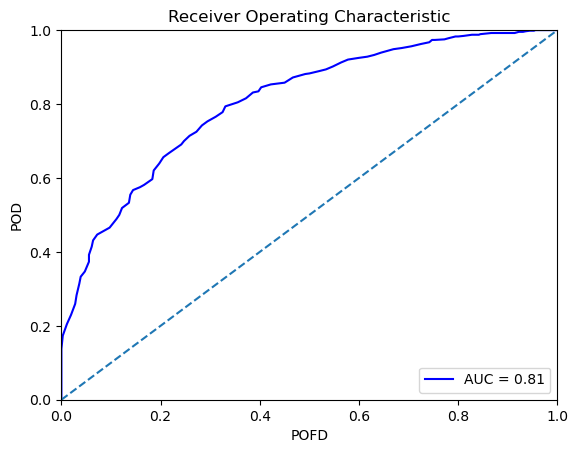

In [7]:
plt.title('Receiver Operating Characteristic')
plt.plot(roc.POFD, roc.POD, 'b', label = 'AUC = %0.2f' % roc.AUC.item())
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('POD')
plt.xlabel('POFD')
plt.show()

- A perfect ROC curve would go from the lower left corner, up to the top left corner, and across to the top right corner.
- If the curve follows the dotted line, it means the forecast has no discrimination ability. This synthetic forecast clearly does have discrimination ability.
- The AUC is the area under the curve. 1 is the maximum value that can be achieved. If we picked a random forecast value from out dataset where the event occured, and a random forecast value when the event did not occur, the AUC tells us the probability that the former forecast value will be greater than the latter.

### Cautionary notes
- ROC or AUC is not a suitable overall performance measure for a probabilistic classifier as it is not a proper scoring rule and is ignorant of calibration (Hand 2009; Hand and Anagnostopoulos 2013, 2023). It is however, a useful tool for understanding potential predictive performance subject to recalibration.
- Non-concave ROC curves like the synthetic example above have several problems (Pesce et al. 2010; Geniting and Vogel 2022). To get around these problems, you can apply isotonic regression to the forecast data before you calculate the ROC curves (Fawcett and Niculescu-Mizil 2007).
- Results may be misleading if two ROC curves cross (Hand 2009).

### References
Fawcett, T. and Niculescu-Mizil, A., 2007. PAV and the ROC convex hull. Machine Learning, 68, pp.97-106.

Gneiting, T. and Vogel, P., 2022. Receiver operating characteristic (ROC) curves: equivalences, beta model, and minimum distance estimation. Machine learning, 111(6), pp.2147-2159.

Hand, D.J., 2009. Measuring classifier performance: a coherent alternative to the area under the ROC curve. Machine learning, 77(1), pp.103-123.

Hand, D.J. and Anagnostopoulos, C., 2013. When is the area under the receiver operating characteristic curve an appropriate measure of classifier performance?. Pattern Recognition Letters, 34(5), pp.492-495.

Hand, D.J. and Anagnostopoulos, C., 2023. Notes on the H-measure of classifier performance. Advances in Data Analysis and Classification, 17(1), pp.109-124.

Pesce, L.L., Metz, C.E. and Berbaum, K.S., 2010. On the convexity of ROC curves estimated from radiological test results. Academic radiology, 17(8), pp.960-968.